In [1]:
import sys
sys.path.append("../")

In [2]:
from sentinelsat import SentinelAPI

# register at https://scihub.copernicus.eu/dhus/#/home
user = ''
password = ''
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [3]:
tile_name = "10SEH"
date = ('20200928', '20200930')

products = api.query(
    date=date, tileid=tile_name,
    platformname='Sentinel-2', producttype="S2MSI1C"
)

In [4]:
import os

dir_ = "sentinelsat/"
try:
    os.mkdir(dir_)
except:
    pass

downloaded_products = api.download_all(products, directory_path=dir_)

In [5]:
from pathlib import Path
import shutil

zip_file_path = Path("sentinelsat/S2B_MSIL1C_20200929T190109_N0209_R013_T10SEH_20200929T213343.zip")
unarchive_dir = zip_file_path.parent
shutil.unpack_archive(zip_file_path, unarchive_dir)

In [6]:
import rasterio
from glob import glob

data_path = str(zip_file_path).replace(".zip", ".SAFE")
band_files = glob(data_path + "/GRANULE/*/IMG_DATA/*.jp2")

def get_band_array(band, band_files):
    band_file = [bf for bf in band_files if band in bf][0]
    array = rasterio.open(band_file).read(1)
    return array

red = get_band_array("B04", band_files)
green = get_band_array("B03", band_files)
blue = get_band_array("B02", band_files)

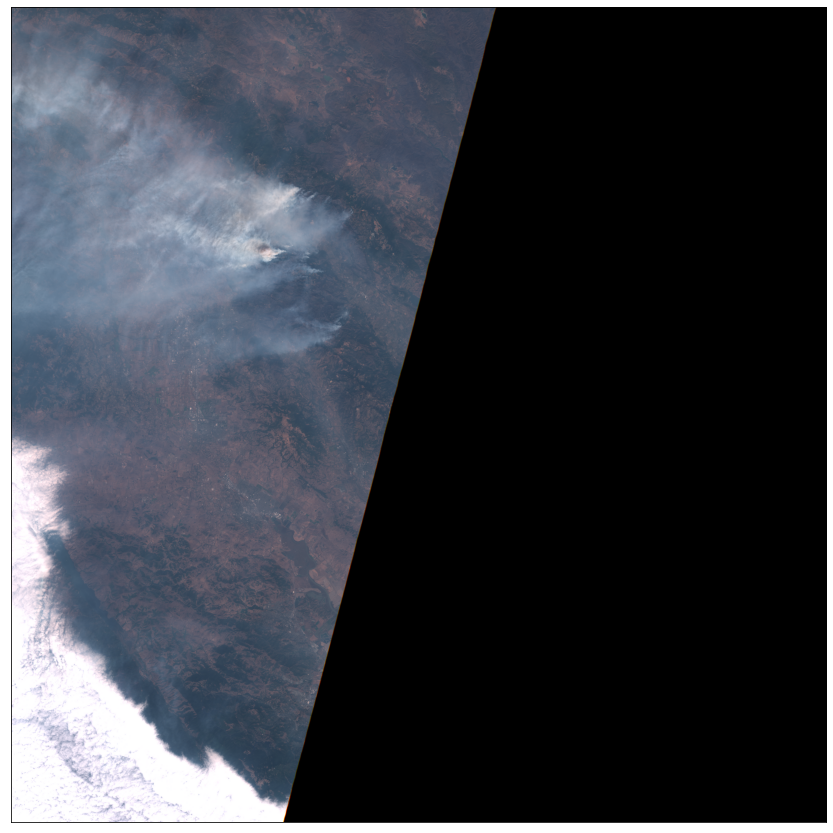

In [7]:
from ds_exploration.plotting_utils import plot_image
import numpy as np
    
rgb = np.dstack([red, green, blue])
plot_image(rgb, factor=5/2e4, clip_range=(0,1))

In [8]:
rgb.shape

(10980, 10980, 3)

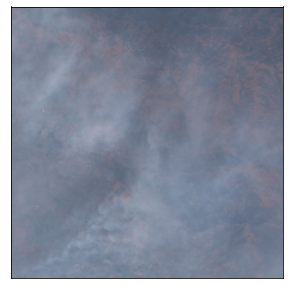

In [9]:
from skimage.util import view_as_blocks

blocks = view_as_blocks(rgb, block_shape=(1098, 1098, 3))
plot_image(blocks[1,1][0, :, :, :], factor=5/2e4, clip_range=(0,1), figsize=(5, 5))

(220, 220, 3) (1098, 1098, 3)


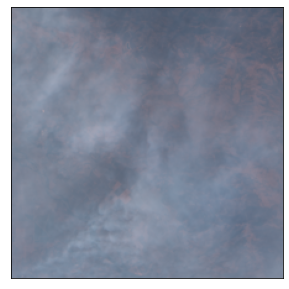

In [10]:
from skimage.transform import rescale

scaled = rescale(blocks[1,1][0, :, :, :] , scale=0.2, preserve_range=True, multichannel=True)
print(scaled.shape, blocks[1,1][0, :, :, :].shape)
plot_image(scaled, factor=5/2e4, clip_range=(0,1), figsize=(5, 5))